# REINFORCE algorithm

In [10]:
import numpy as np
import gym
from gym import spaces

class ContinuousInventoryEnv(gym.Env):
    def __init__(self, min_inv=-10, max_inv=10, max_order=10, horizon=100):
        super().__init__()
        self.min_inv, self.max_inv = min_inv, max_inv
        self.max_order        = max_order
        self.horizon          = horizon
        self.p, self.a_cost, self.b_cost = 1.0, 1.0, 2.0

        # obs = [inventory level, time step]
        self.observation_space = spaces.Box(
            low=np.array([min_inv, 0], dtype=np.float32),
            high=np.array([max_inv, horizon], dtype=np.float32),
            dtype=np.float32
        )

        # raw policy output ∊ ℝ → scale to [0,max_order]
        self.action_space = spaces.Box(
            low=np.array([0.], dtype=np.float32),
            high=np.array([max_order], dtype=np.float32),
            dtype=np.float32
        )

        self.reset()

    def reset(self):
        self.s = np.random.randint(self.min_inv, self.max_inv+1)
        self.t = 0
        return np.array([self.s, self.t], dtype=np.float32)

    def step(self, action):
        # ensure scalar
        a = float(np.array(action).flatten()[0])
        # enforce bounds
        a = float(max(0, min(a, self.max_order)))

        # random continuous demand
        w = np.random.uniform(0, 10)

        # next inventory BEFORE clamping
        s_next = self.s + a - w

        # clamp to physical bounds
        s_next_clamped = np.clip(s_next, self.min_inv, self.max_inv)
        self.s = s_next_clamped
        self.t += 1

        # compute cost on clamped inventory
        if s_next_clamped >= 0:
            cost = self.p * a + self.a_cost * s_next_clamped
        else:
            cost = self.p * a + self.b_cost * (-s_next_clamped)

        reward = -cost
        done   = (self.t >= self.horizon)

        obs = np.array([self.s, self.t], dtype=np.float32)
        return obs, reward, done, {}


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, hidden_size=128):
        super().__init__()
        self.fc1     = nn.Linear(state_dim, hidden_size)
        self.mean    = nn.Linear(hidden_size, 1)
        self.log_std = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x  = F.relu(self.fc1(x))
        mu = self.mean(x)
        std = torch.exp(self.log_std).clamp(min=1e-3, max=2.0)
        return mu, std

    def get_action(self, state):
        mu, std = self(state)
        eps     = torch.randn_like(mu)
        action  = mu + eps * std
        log_prob = (
            -0.5 * ((action - mu) / std).pow(2)
            - self.log_std
            - 0.5 * np.log(2 * np.pi)
        )
        return action, log_prob.squeeze(-1)


In [12]:
import torch.optim as optim
import matplotlib.pyplot as plt

q_values = []  # track average Q-value per episode

def reinforce_cont(env, policy, num_episodes=500, gamma=1.0, lr=1e-3, log_interval=10):
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    all_rewards = []

    for ep in range(1, num_episodes + 1):
        state = env.reset()
        log_probs, rewards = [], []
        done = False

        while not done:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_tensor, logp = policy.get_action(state_tensor)

            # convert to numpy scalar in [0, max_order]
            action_np = action_tensor.detach().numpy().flatten()[0]
            next_state, reward, done, _ = env.step(action_np)

            log_probs.append(logp)
            rewards.append(reward)
            state = next_state

        # compute discounted returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        # average return as proxy for average Q(s,a)
        avg_q = returns.mean().item()
        q_values.append(avg_q)


        # policy gradient step
        loss = torch.stack([-lp * Gt for lp, Gt in zip(log_probs, returns)]).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_reward = sum(rewards)
        all_rewards.append(total_reward)
        if ep % log_interval == 0:
            print(f"Episode {ep}/{num_episodes}, total reward: {total_reward:.2f}")

    plt.plot(all_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE Continuous Action Learning Curve')
    plt.grid(True)
    plt.show()

    return all_rewards


Episode 10/500, total reward: -1877.87
Episode 20/500, total reward: -1686.49
Episode 30/500, total reward: -1525.72
Episode 40/500, total reward: -1752.94
Episode 50/500, total reward: -1553.13
Episode 60/500, total reward: -1541.69
Episode 70/500, total reward: -1622.80
Episode 80/500, total reward: -1529.63
Episode 90/500, total reward: -1691.82
Episode 100/500, total reward: -1594.24
Episode 110/500, total reward: -1468.13
Episode 120/500, total reward: -1672.51
Episode 130/500, total reward: -1567.41
Episode 140/500, total reward: -1721.80
Episode 150/500, total reward: -1603.01
Episode 160/500, total reward: -1692.41
Episode 170/500, total reward: -1659.76
Episode 180/500, total reward: -1512.19
Episode 190/500, total reward: -1608.65
Episode 200/500, total reward: -1434.28
Episode 210/500, total reward: -1621.35
Episode 220/500, total reward: -1411.16
Episode 230/500, total reward: -1523.87
Episode 240/500, total reward: -1491.29
Episode 250/500, total reward: -1520.12
Episode 2

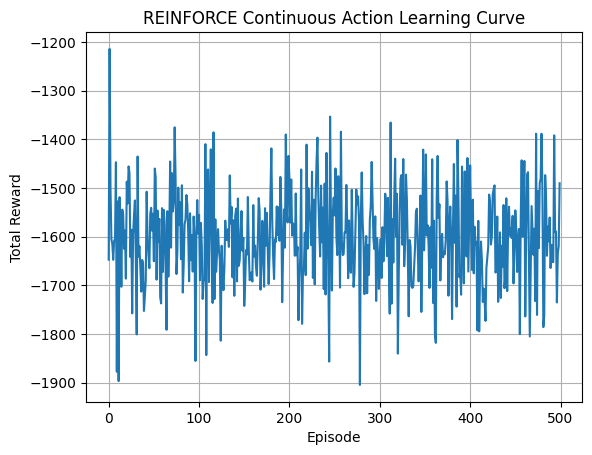

In [13]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv(min_inv=-10, max_inv=10, max_order=10, horizon=100)
    policy = GaussianPolicy(state_dim=env.observation_space.shape[0])
    reinforce_cont(env, policy, num_episodes=500, gamma=0.9, lr=1e-3)


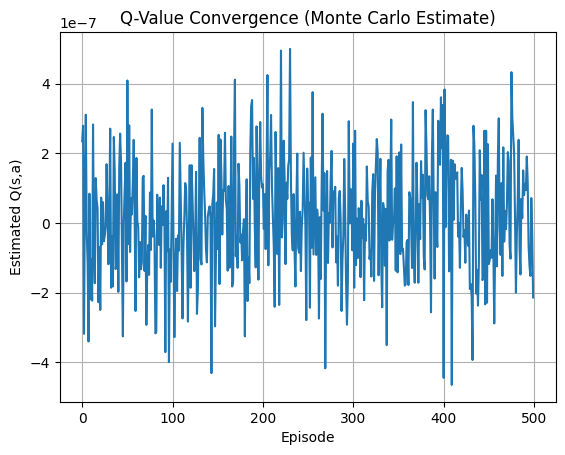

In [14]:
plt.figure()
plt.plot(q_values)
plt.xlabel('Episode')
plt.ylabel('Estimated Q(s,a)')
plt.title('Q-Value Convergence (Monte Carlo Estimate)')
plt.grid(True)
plt.show()


In [15]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict

def reinforce_cont(env, policy, num_episodes=500, gamma=1.0, lr=1e-3, log_interval=50):
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    all_rewards = []      # total undiscounted reward per episode
    q_values   = []      # G_0 per episode (estimate of Q(start,a))
    state_returns = []    # list of (t, G_t) pairs from all episodes

    for ep in range(1, num_episodes+1):
        state = env.reset()
        log_probs, rewards = [], []
        ep_states = []    # save (state, t) for each step
        done = False

        # generate one episode
        while not done:
            # prepare state tensor
            st_t = torch.from_numpy(state).float().unsqueeze(0)
            action_t, logp_t = policy.get_action(st_t)
            # convert to scalar and step
            action_np = action_t.detach().numpy().flatten()[0]
            next_state, reward, done, _ = env.step(action_np)

            # record
            ep_states.append((state.copy(), env.t))  
            log_probs.append(logp_t)
            rewards.append(reward)

            state = next_state

        # compute discounted returns G_t
        G = 0
        returns = []
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)

        # 1) track total undiscounted reward
        total_rew = sum(rewards)
        all_rewards.append(total_rew)

        # 2) track Q-value estimate for the start state:
        #    here G_0 is the return from time 0
        q_values.append(returns[0].item())

        # 3) accumulate (t, G_t) for V(s) vs t
        for ((s_vec, t_step), Gt) in zip(ep_states, returns):
            # if you want to average by *state* as well, store s_vec
            state_returns.append((t_step, Gt.item()))

        # normalize returns for the gradient step
        norm_returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # policy gradient update
        loss = torch.stack([
            -lp * Gt for lp, Gt in zip(log_probs, norm_returns)
        ]).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ep % log_interval == 0:
            print(f"[Episode {ep}/{num_episodes}]  Total Reward: {total_rew:.1f}  Q₀: {q_values[-1]:.1f}")

    # === PLOT 1: Total Reward per Episode ===
    plt.figure(figsize=(6,4))
    plt.plot(all_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("REINFORCE Continuous Action Learning Curve")
    plt.grid(True)

    # === PLOT 2: Q-Value Convergence (G₀) ===
    plt.figure(figsize=(6,4))
    plt.plot(q_values)
    plt.xlabel("Episode")
    plt.ylabel(r"Estimated $Q(s_0,a_0)=G_0$")
    plt.title("Q-Value Convergence (Monte Carlo Estimate)")
    plt.grid(True)

    # === PLOT 3: V(s) vs t ===
    # average G_t over all episodes for each time step t
    v_dict = defaultdict(list)
    for t_step, Gt in state_returns:
        v_dict[t_step].append(Gt)

    t_vals = sorted(v_dict.keys())
    v_vals = [ np.mean(v_dict[t]) for t in t_vals ]

    plt.figure(figsize=(6,4))
    plt.plot(t_vals, v_vals, marker='o')
    plt.xlabel("Time step $t$")
    plt.ylabel(r"Estimated $V(s)$ at $t$")
    plt.title("State-Value $V(s)$ vs Time")
    plt.grid(True)

    plt.show()

    return all_rewards, q_values, (t_vals, v_vals)


[Episode 50/500]  Total Reward: -1906.0  Q₀: -186.1
[Episode 100/500]  Total Reward: -1615.9  Q₀: -140.5
[Episode 150/500]  Total Reward: -1985.1  Q₀: -187.7
[Episode 200/500]  Total Reward: -1844.4  Q₀: -201.8
[Episode 250/500]  Total Reward: -1851.7  Q₀: -205.4
[Episode 300/500]  Total Reward: -1702.1  Q₀: -169.7
[Episode 350/500]  Total Reward: -1810.9  Q₀: -204.6
[Episode 400/500]  Total Reward: -1675.2  Q₀: -143.3
[Episode 450/500]  Total Reward: -1852.8  Q₀: -170.3
[Episode 500/500]  Total Reward: -1903.0  Q₀: -188.7


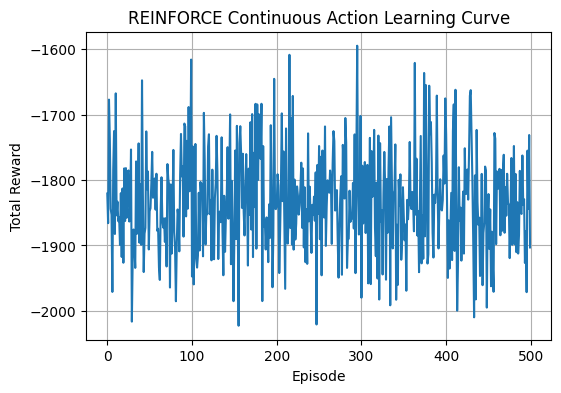

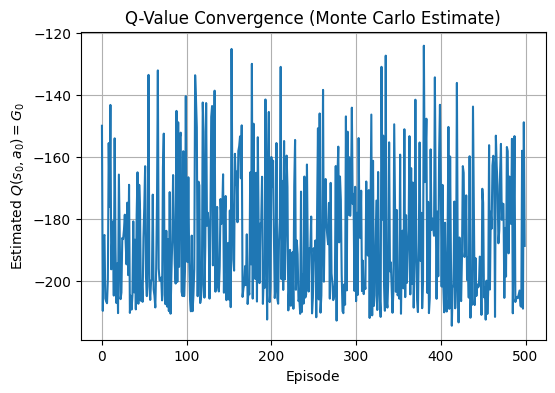

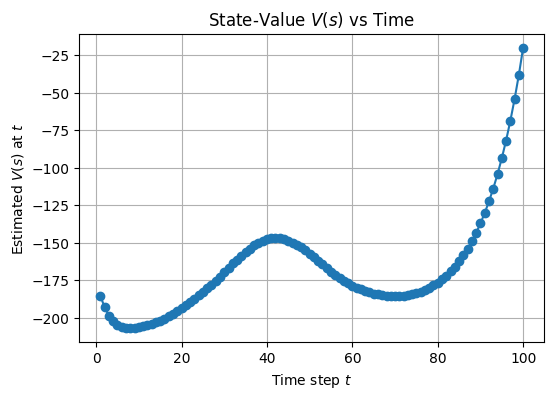

In [16]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv(min_inv=-10, max_inv=10, max_order=10, horizon=100)
    policy = GaussianPolicy(state_dim=env.observation_space.shape[0])
    reinforce_cont(env, policy, num_episodes=500, gamma=0.9, lr=1e-3)


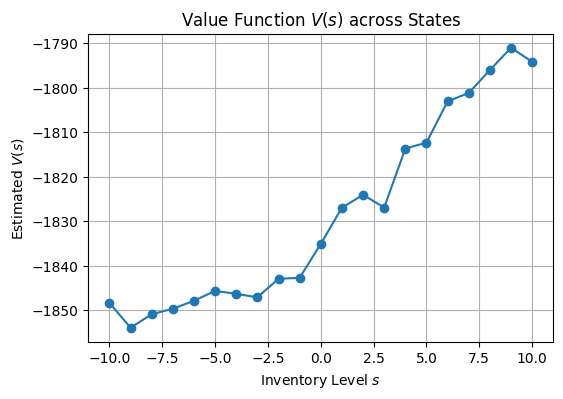

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def estimate_V_of_s(env, policy, states, num_rollouts=200, gamma=1.0):
    V = {}
    for s0 in states:
        returns = []
        for _ in range(num_rollouts):
            # reset env to exactly s0
            env.s = s0
            env.t = 0
            state = np.array([env.s, env.t], dtype=np.float32)

            G = 0; discount = 1.0
            done = False
            while not done:
                st_t = torch.from_numpy(state).float().unsqueeze(0)
                action_t, _ = policy.get_action(st_t)
                a = action_t.detach().numpy().flatten()[0]
                next_state, r, done, _ = env.step(a)
                G += discount * r
                discount *= gamma
                state = next_state
            returns.append(G)
        V[s0] = np.mean(returns)
    
    # plot
    s_vals = sorted(V.keys())
    v_vals = [V[s] for s in s_vals]
    plt.figure(figsize=(6,4))
    plt.plot(s_vals, v_vals, marker='o')
    plt.xlabel("Inventory Level $s$")
    plt.ylabel("Estimated $V(s)$")
    plt.title("Value Function $V(s)$ across States")
    plt.grid(True)
    plt.show()
    return V

# Usage (after training):
states = range(env.min_inv, env.max_inv+1)
V_est = estimate_V_of_s(env, policy, states)


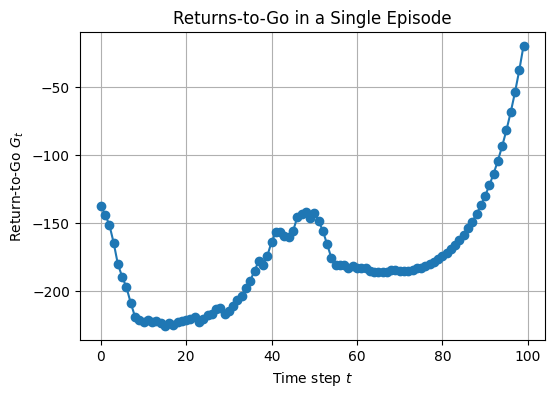

In [18]:
gamma = 0.9

# generate one trajectory
state = env.reset()
done = False
rewards = []
while not done:
    st_t = torch.from_numpy(state).float().unsqueeze(0)
    action_t, _ = policy.get_action(st_t)
    a = action_t.detach().numpy().flatten()[0]
    state, r, done, _ = env.step(a)
    rewards.append(r)

# compute G_t
G = 0
returns_to_go = []
for r in reversed(rewards):
    G = r + gamma*G
    returns_to_go.insert(0, G)

# plot
plt.figure(figsize=(6,4))
plt.plot(range(len(returns_to_go)), returns_to_go, marker='o')
plt.xlabel("Time step $t$")
plt.ylabel(r"Return-to-Go $G_t$")
plt.title("Returns-to-Go in a Single Episode")
plt.grid(True)
plt.show()
